# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [55]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.339255
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Since the classifer is not trained and the parameters W are initialized randomly, it is expected that the probabilities given by the classifier will be almost uniform. Since there are 10 classes, each class will have a probability of 1/10.


In [66]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.287075 analytic: 2.287074, relative error: 2.558874e-08
numerical: -1.536022 analytic: -1.536022, relative error: 6.822975e-08
numerical: 0.029777 analytic: 0.029776, relative error: 3.101857e-06
numerical: 2.040228 analytic: 2.040228, relative error: 4.633958e-08
numerical: 2.847185 analytic: 2.847185, relative error: 1.713874e-08
numerical: -4.636888 analytic: -4.636888, relative error: 2.525005e-08
numerical: 0.095685 analytic: 0.095684, relative error: 5.175049e-07
numerical: -1.340551 analytic: -1.340552, relative error: 1.211678e-08
numerical: -0.593547 analytic: -0.593547, relative error: 1.410923e-07
numerical: 0.666647 analytic: 0.666646, relative error: 8.947591e-08
numerical: -0.506153 analytic: -0.506153, relative error: 1.024326e-07
numerical: -0.110820 analytic: -0.110820, relative error: 3.275264e-07
numerical: 1.768962 analytic: 1.768962, relative error: 3.240344e-08
numerical: -2.752917 analytic: -2.752917, relative error: 9.330663e-09
numerical: 0.934436 

In [94]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.339255e+00 computed in 0.154536s
vectorized loss: 2.339255e+00 computed in 0.006837s
Loss difference: 0.000000
Gradient difference: 0.000000


In [99]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_runs = 50
num_iters = 1500
verbose = False
log_lr = [-6.8, -6.6]
log_rs = [3.8, 4.0]

for run in range(num_runs):
    loglr = np.random.uniform(log_lr[0], log_lr[1])
    logrs = np.random.uniform(log_rs[0], log_rs[1])
    lr = np.power(10, loglr)
    rs = np.power(10, logrs)
    
    print('Run %d/%d: evaluating lr=%.6e, rs=%.6e' % (run, num_runs, loglr, logrs))
    tic = time.time()
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                          num_iters=num_iters, verbose=verbose)
    training_accuracy =  np.mean(y_train == softmax.predict(X_train))
    validation_accuracy =  np.mean(y_val == softmax.predict(X_val))
    
    results[(lr, rs)] = (training_accuracy, validation_accuracy)
    toc = time.time()
    print('\ttook %fs' % (toc - tic))
    print('\ttraining accuracy=%.6f' % (training_accuracy))
    print('\tvalidation accuracy=%.6f' % (validation_accuracy))
    
    if validation_accuracy > best_val:
        print('\tBest model!')
        best_val = validation_accuracy
        best_softmax = softmax
    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Run 0/50: evaluating lr=-6.624667e+00, rs=3.919365e+00
	took 3.788810s
	training accuracy=0.359816
	validation accuracy=0.372000
	Best model!
Run 1/50: evaluating lr=-6.657436e+00, rs=3.885495e+00
	took 3.488577s
	training accuracy=0.359000
	validation accuracy=0.379000
	Best model!
Run 2/50: evaluating lr=-6.704270e+00, rs=3.971619e+00
	took 3.483963s
	training accuracy=0.361755
	validation accuracy=0.377000
Run 3/50: evaluating lr=-6.680718e+00, rs=3.929727e+00
	took 3.481437s
	training accuracy=0.361286
	validation accuracy=0.375000
Run 4/50: evaluating lr=-6.713427e+00, rs=3.914275e+00
	took 3.653010s
	training accuracy=0.358449
	validation accuracy=0.371000
Run 5/50: evaluating lr=-6.793819e+00, rs=3.972284e+00
	took 3.622078s
	training accuracy=0.359755
	validation accuracy=0.368000
Run 6/50: evaluating lr=-6.714691e+00, rs=3.902541e+00
	took 3.570599s
	training accuracy=0.363633
	validation accuracy=0.372000
Run 7/50: evaluating lr=-6.734868e+00, rs=3.818463e+00
	took 3.573857s


In [100]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


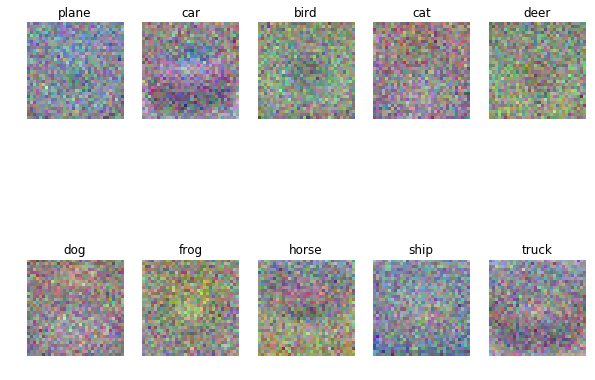

In [101]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])